# EMBC trial-level analysis

In [2]:
path_to_base_package = '../..'
import sys
# setting path
sys.path.append(f"{path_to_base_package}")
import mne
mne.viz.set_3d_backend('pyvistaqt')

import json
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from mna.utils.data_access import *
# 1. Read a RN App, converted pkl file, and create the metadata and data structure

Using pyvistaqt 3d backend.



# Aux functions, read files

In [3]:
output_dir = f"{path_to_base_package}/output/batch_analysis_motor/"
output_dir_non_baseline_non_average = f"{output_dir}/saved_files_non_baseline_non_average/" # saved files directory (trial or motor)
remove_sessions = [(15,1),(22,1)]
rel_regions = {'premotor_regions': ['FC3', 'FC1', 'FCz', 'FC2', 'FC4'], 'dorsolateral_prefrontal': ['AF3', 'AFz', 'AF4'], 'intermediate_frontal': ['F3', 'F1', 'Fz', 'F2', 'F4']}
all_regions = sum(rel_regions.values(),[])

# reading the brodmann atlas mappings
# confirmed in freesurfer MNE template as mapping into these regions: http://www.brainm.com/software/pubs/dg/BA_10-20_ROI_Talairach/nearesteeg.htm
with open(f"{path_to_base_package}/data/annotated/brodmann_area_to_functional_name.json") as f:
    data = f.read()
brodmann_mappings = json.loads(data, object_hook=lambda d: {int(k) if k.isdigit() else k: v for k, v in d.items()})


pupil_df = pd.read_csv(f"{path_to_base_package}/output/pupil_exposure/participant_level_exposure_fits.csv")
exposure_epochs = get_exposure_epochs(f"{path_to_base_package}/output/exposure/exposure_epochs.pickle")
trial_dfs = pd.read_csv(f"{output_dir}all_results.csv")
p_val_criteria = 0.05
preturn = 1000

Adding metadata with 5 columns
509 matching events found
No baseline correction applied


# Clean up dfs

In [4]:
# seaborn
def norm_features(x_train, x_test):

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_norm = scaler.transform(x_train)
    x_test_norm = scaler.transform(x_test)

    return x_train_norm, x_test_norm

sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

motor_outlier_cols = ['abs_sum_delta_steer_input']
cols_to_outlier_detect = ['bpm', 'sdnn', 'rmssd', 'pnn50']
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade',
            'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['bpm', 'sdnn', 'rmssd', 'pnn50']  # rmssd = parasympathetic
motor_cols = ['abs_sum_delta_steer_input', 'abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input']
def remove_motor_overlaps(test_df):
    test_df = test_df.reset_index(drop=True)
    trial_list = list(zip(test_df.trial_start_time, test_df.trial_end_time, test_df.index))
    overlaps = []
    for i in range(1,len(trial_list)):
        base_data = trial_list[i]
        check_data = trial_list[i-1]
        if base_data[1] > check_data[0] and base_data[1] <= check_data[1]:
            overlaps.append((base_data, check_data, base_data[1]-check_data[0], base_data[2], check_data[2]))
            assert base_data[1]-check_data[0] != 1, 'Major issue, repeating trials found. Double check'
    drop_rows = []
    for overlap in overlaps:
        row_1 = test_df.iloc[overlap[-1]]
        row_2 = test_df.iloc[overlap[-2]]
        if np.argmax([row_1.Abs_Steer_Wheel_Degree, row_2.Abs_Steer_Wheel_Degree]) == 0: # if row 1 has larger steer motion, drop the other
            drop_rows.append(overlap[-2])
        else:
            drop_rows.append(overlap[-1])
    test_df = test_df.drop(drop_rows,axis=0)
    return test_df

def clean_up_trials(input_df):
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block', 'trial'])
    # nan, outliers
    #for col in motor_outlier_cols:
    #    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    #all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation'] - all_dfs_final[
        'trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade'] - all_dfs_final[
        'trial_start_time']

    all_dfs_final[
        'throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input / all_dfs_final.abs_sum_delta_brake_input
    return all_dfs_final


trial_dfs = clean_up_trials(trial_dfs)
trial_dfs = trial_dfs.loc[~trial_dfs.ppid_session.isin([f"{es[0]}_{es[1]}" for es in remove_sessions])]

# luminance effect removal from pupil diameter
trial_dfs['Raw Left Pupil Diameter'] = trial_dfs['Left Pupil Diameter']
trial_dfs = trial_dfs.reset_index(drop=True)
adjustments=[]
for index, row in trial_dfs.iloc[1:].iterrows():
    last_ppid = trial_dfs.iloc[index - 1].ppid
    last_session = trial_dfs.iloc[index - 1].session
    last_trial = trial_dfs.iloc[index - 1].trial
    last_opacity = trial_dfs.iloc[index - 1].density
    if ((row.ppid == last_ppid) & (row.session == last_session) & (row.trial == last_trial + 1)):  # if continuous
        # if there is a significant effect of opacity on pupil
        if pupil_df.loc[pupil_df['sub'] == last_ppid, 'p_opacities'].values < p_val_criteria:
            this_opacity = row.density
            this_pupil_diameter = row['Left Pupil Diameter']
            weight = pupil_df.loc[pupil_df['sub'] == last_ppid, 'w_opacities']
            adjustment = ((this_opacity - last_opacity) * weight).values[0]
            trial_dfs.iloc[index, trial_dfs.columns.get_loc('Left Pupil Diameter')] += adjustment

# pupil bins
trial_dfs['pupil_bin'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
trial_dfs['pupil_bin_encoded'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))

print(pupil_df[['sub','w_opacities','const','p_opacities']].to_latex(index=False,float_format="{:0.2f}".format))

\begin{tabular}{rrrr}
\toprule
 sub &  w\_opacities &  const &  p\_opacities \\
\midrule
  20 &        -0.63 &   0.80 &         0.00 \\
  14 &        -0.15 &   0.24 &         0.00 \\
  12 &        -1.06 &   0.96 &         0.00 \\
  22 &        -1.18 &   1.33 &         0.00 \\
  16 &        -0.27 &   0.37 &         0.00 \\
  18 &        -1.23 &   0.98 &         0.00 \\
  19 &         0.34 &  -0.13 &         0.00 \\
  21 &        -0.44 &   0.46 &         0.00 \\
  15 &        -3.06 &   2.15 &         0.00 \\
  13 &        -1.11 &   1.13 &         0.00 \\
  23 &        -0.55 &   0.58 &         0.00 \\
  17 &        -0.60 &   0.45 &         0.00 \\
\bottomrule
\end{tabular}



# Trial data accuracy

### Using behavioral, eye data and autonomic meaures to predict pupil-linked arousal state to predict preceived arousal

size of dataset (477, 13) lost 478 trials or 0.5005235602094241 as a result of removing nan values given the predictors
Class 1 proportion in training dataset 0.5546218487394958
Test AUC: 0.5733251003396109 Accuracy: 0.5833333333333334
Elapsed time to compute the importances: 0.004 seconds
Elapsed time to compute the importances: 3.318 seconds


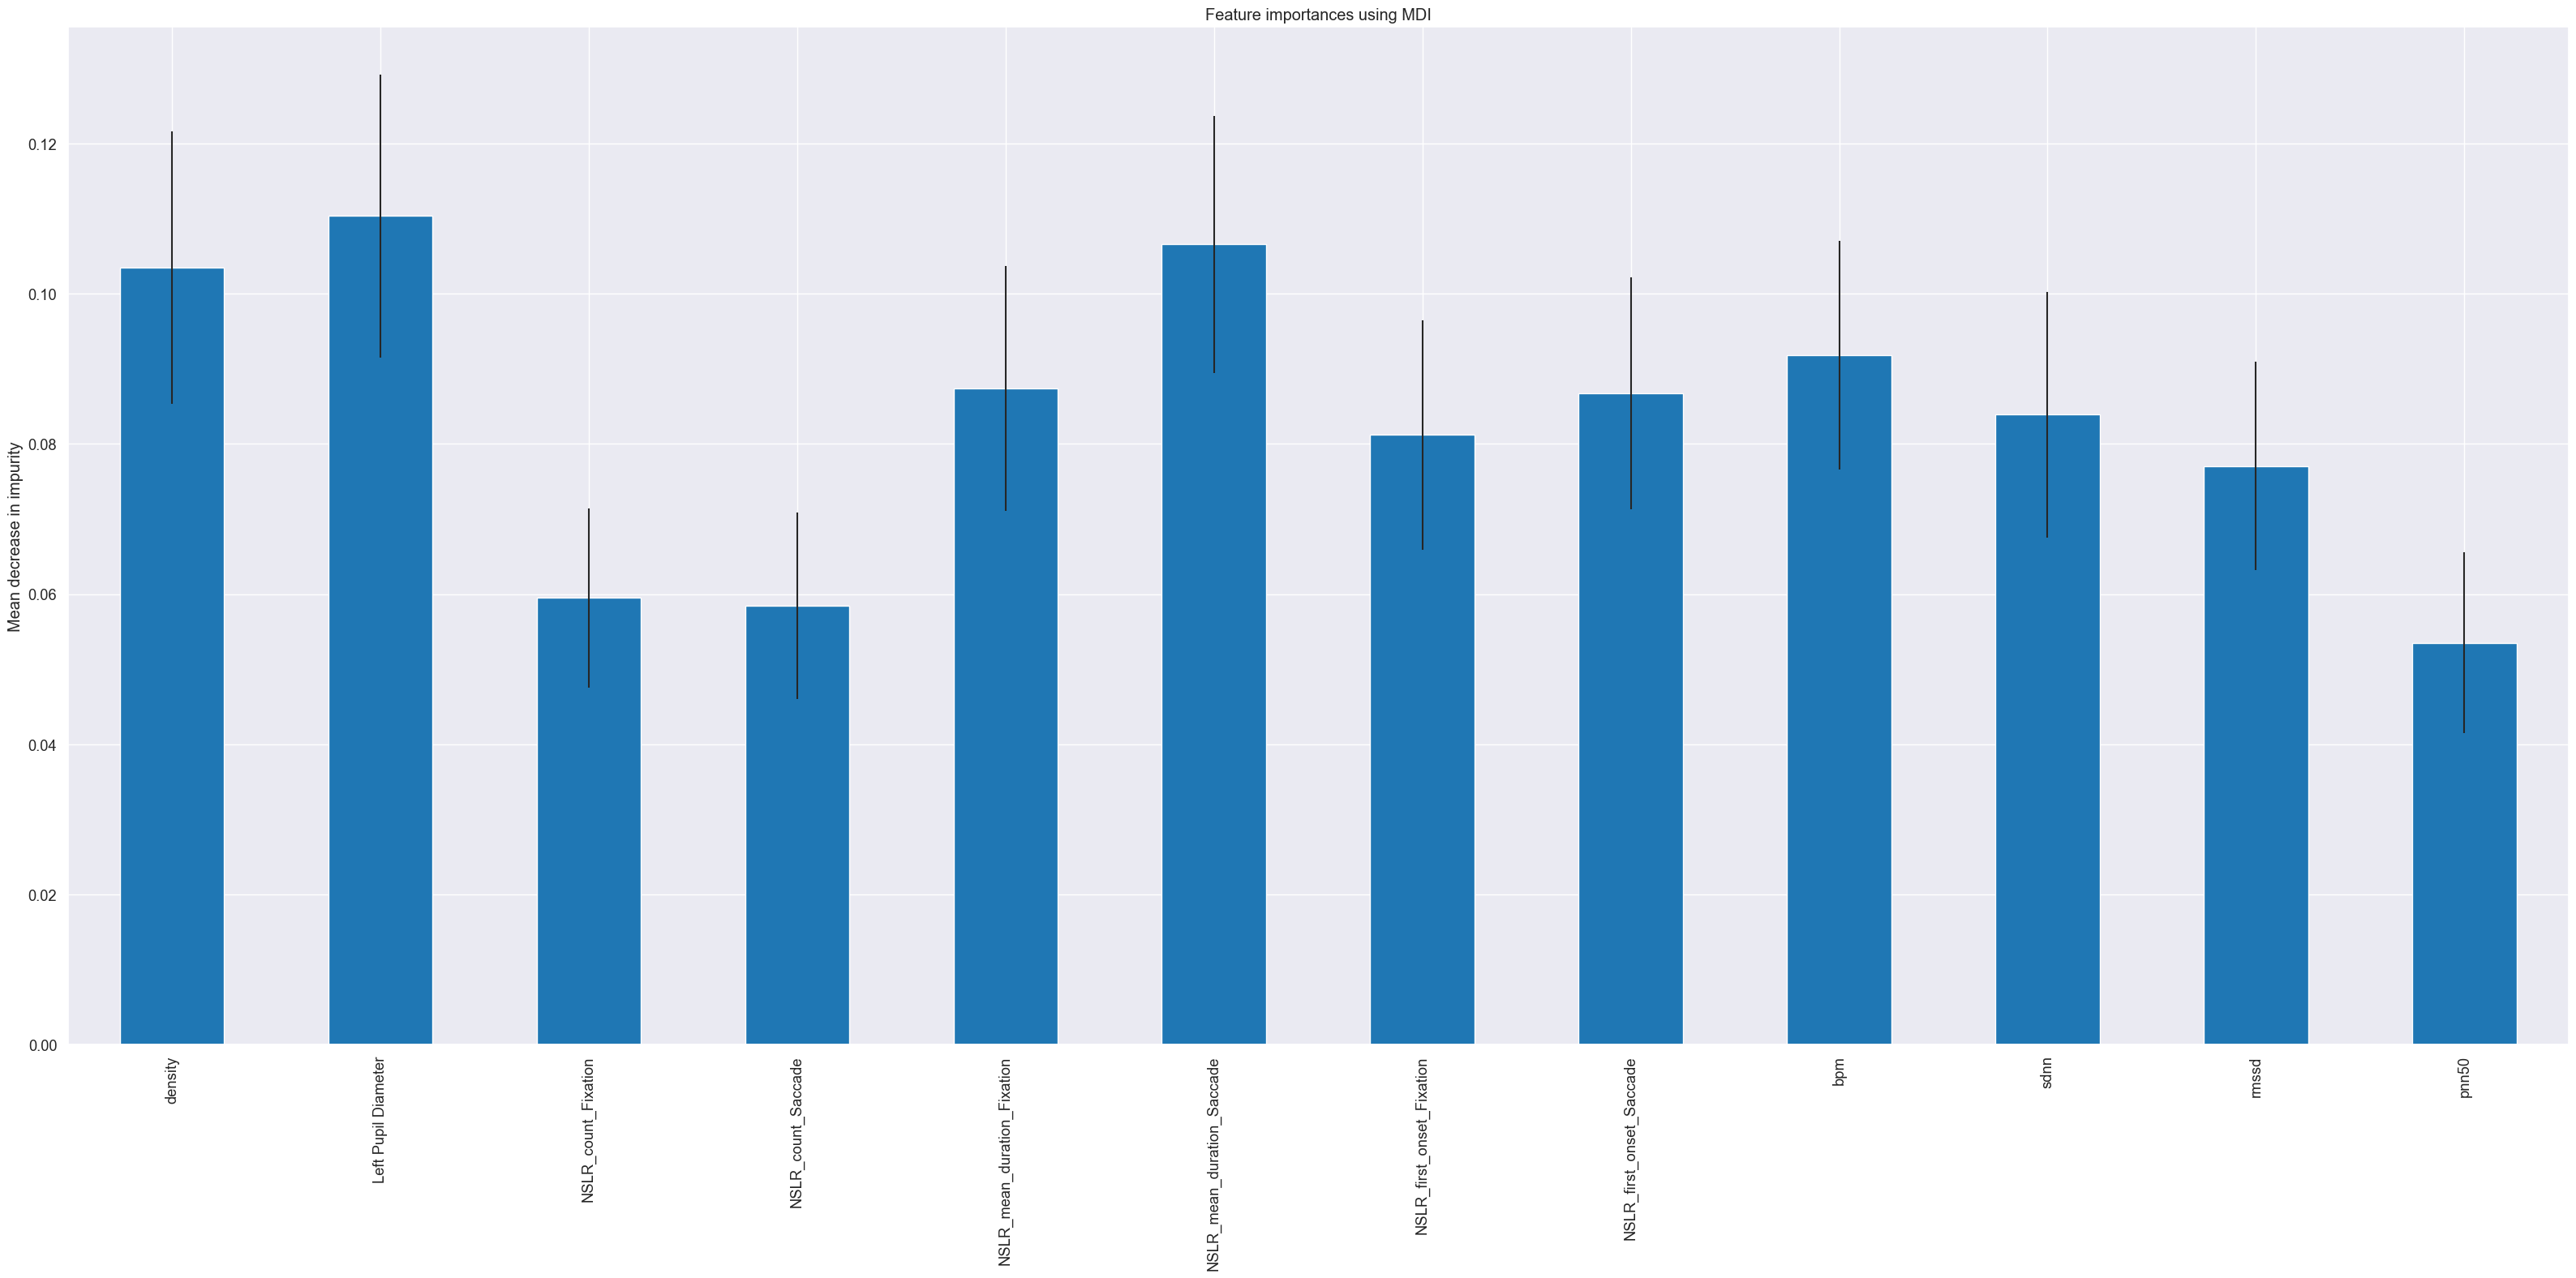

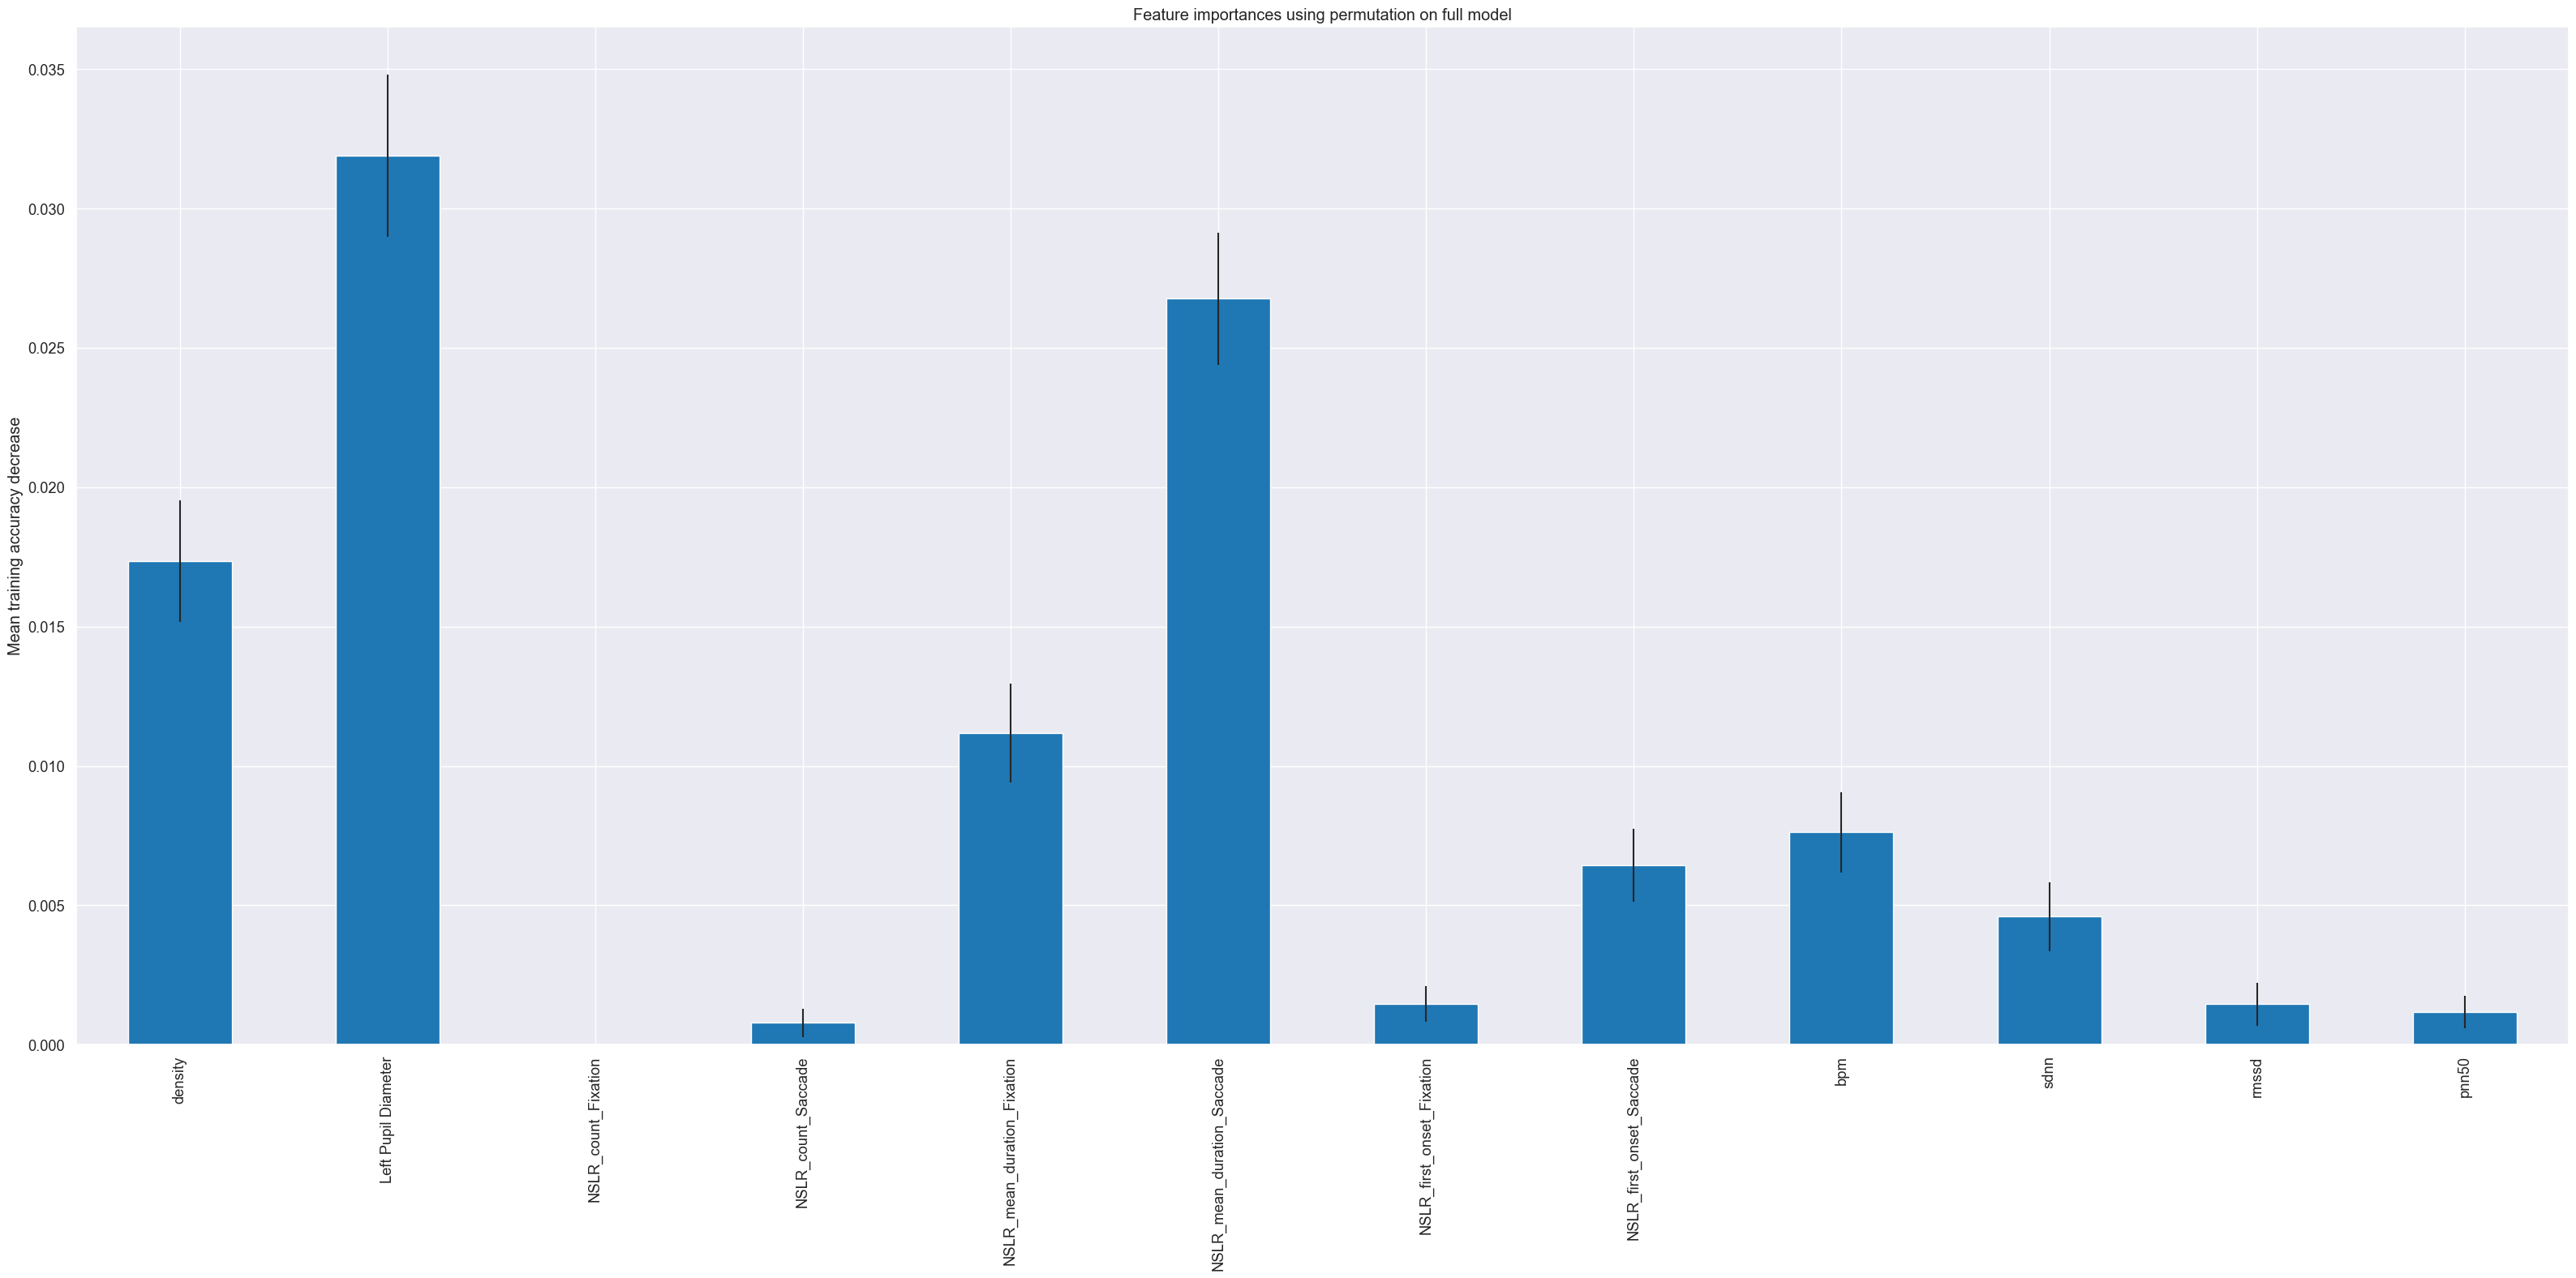

In [14]:
from sklearn.inspection import permutation_importance
import scipy.stats as st
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import time
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score

def rf_prediction_importances(input_df, prediction, predictors,pred_type = 'classification', calc_importances=True, seed=None, plot=True):
    prediction = prediction
    predictors = predictors

    # drop na
    motor_dfs_nonnan = input_df[predictors+[prediction]].dropna()
    print(f"size of dataset {motor_dfs_nonnan.shape} lost {len(input_df)-len(motor_dfs_nonnan)} trials or {(len(input_df)-len(motor_dfs_nonnan))/len(input_df)} as a result of removing nan values given the predictors")

    y = motor_dfs_nonnan[prediction]
    X = motor_dfs_nonnan[predictors]
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=seed)
    feature_names = list(X.columns)
    if pred_type == 'classification':
        forest = RandomForestClassifier(random_state=seed)
    elif pred_type == 'regression':
        forest = RandomForestRegressor(random_state=seed)
    forest.fit(X_train, y_train)

    # results
    if pred_type == 'classification':
        print(f"Class 1 proportion in training dataset {(y_train==1).sum()/len(y_train)}")
        print(f"Test AUC: {roc_auc_score(y_test, forest.predict_proba(X_test)[:,1])} Accuracy: {accuracy_score(y_test, forest.predict(X_test))}")
    elif pred_type == 'regression':
        print(f"Test R2: {r2_score(y_test, forest.predict(X_test))}")
    # importances
    if calc_importances:
        start_time = time.time()
        importances = forest.feature_importances_
        data = [tree.feature_importances_ for tree in forest.estimators_]
        cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data,axis=0), scale=st.sem(data))
        std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
        elapsed_time = time.time() - start_time

        print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
        forest_importances = pd.Series(importances, index=feature_names)
        if plot:
            fig, ax = plt.subplots(figsize=(32,16))
            forest_importances.plot.bar(yerr=cis[1]-cis[0], ax=ax)
            ax.set_title("Feature importances using MDI")
            ax.set_ylabel("Mean decrease in impurity")
            fig.tight_layout()

    if calc_importances:
        start_time = time.time()
        result = permutation_importance(
            forest, X_train, y_train, n_repeats=100, random_state=seed, n_jobs=2 # using training set
        )
        elapsed_time = time.time() - start_time
        print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
        data = result.importances.T
        cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data,axis=0), scale=st.sem(data))

        forest_importances = pd.Series(result.importances_mean, index=feature_names)
        forest_importances = np.clip(forest_importances,0,None) # clip the importances at 0 minimum so it makes sense, only relevant for small DFs
        if plot:
            fig, ax = plt.subplots(figsize=(32,16))
            forest_importances.plot.bar(yerr=cis[1]-cis[0], ax=ax)
            ax.set_title("Feature importances using permutation on full model")
            if pred_type == 'classification':
                ax.set_ylabel("Mean training accuracy decrease")
            elif pred_type == 'regression':
                ax.set_ylabel("Mean training R2 decrease")
            fig.tight_layout()
            plt.show()

prediction = 'spoken_difficulty_encoded'
predictors = ['density', 'Left Pupil Diameter', 'NSLR_count_Fixation', 'NSLR_count_Saccade', 'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade', 'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade', 'bpm', 'sdnn', 'rmssd', 'pnn50']

# filter rows
trial_dfs_filtered = trial_dfs.copy()
trial_dfs_filtered = trial_dfs_filtered[trial_dfs_filtered['spoken_difficulty'] != 'unknown']

rf_prediction_importances(trial_dfs_filtered, prediction, predictors, seed=42, calc_importances=True, plot=True)

### Using EEG to predict perceived arousal

size of dataset (680, 23) lost 275 trials or 0.2879581151832461 as a result of removing nan values given the predictors
Class 1 proportion in training dataset 0.5980392156862745
Test AUC: 0.5670045045045045 Accuracy: 0.5764705882352941
Elapsed time to compute the importances: 0.004 seconds
Elapsed time to compute the importances: 7.668 seconds


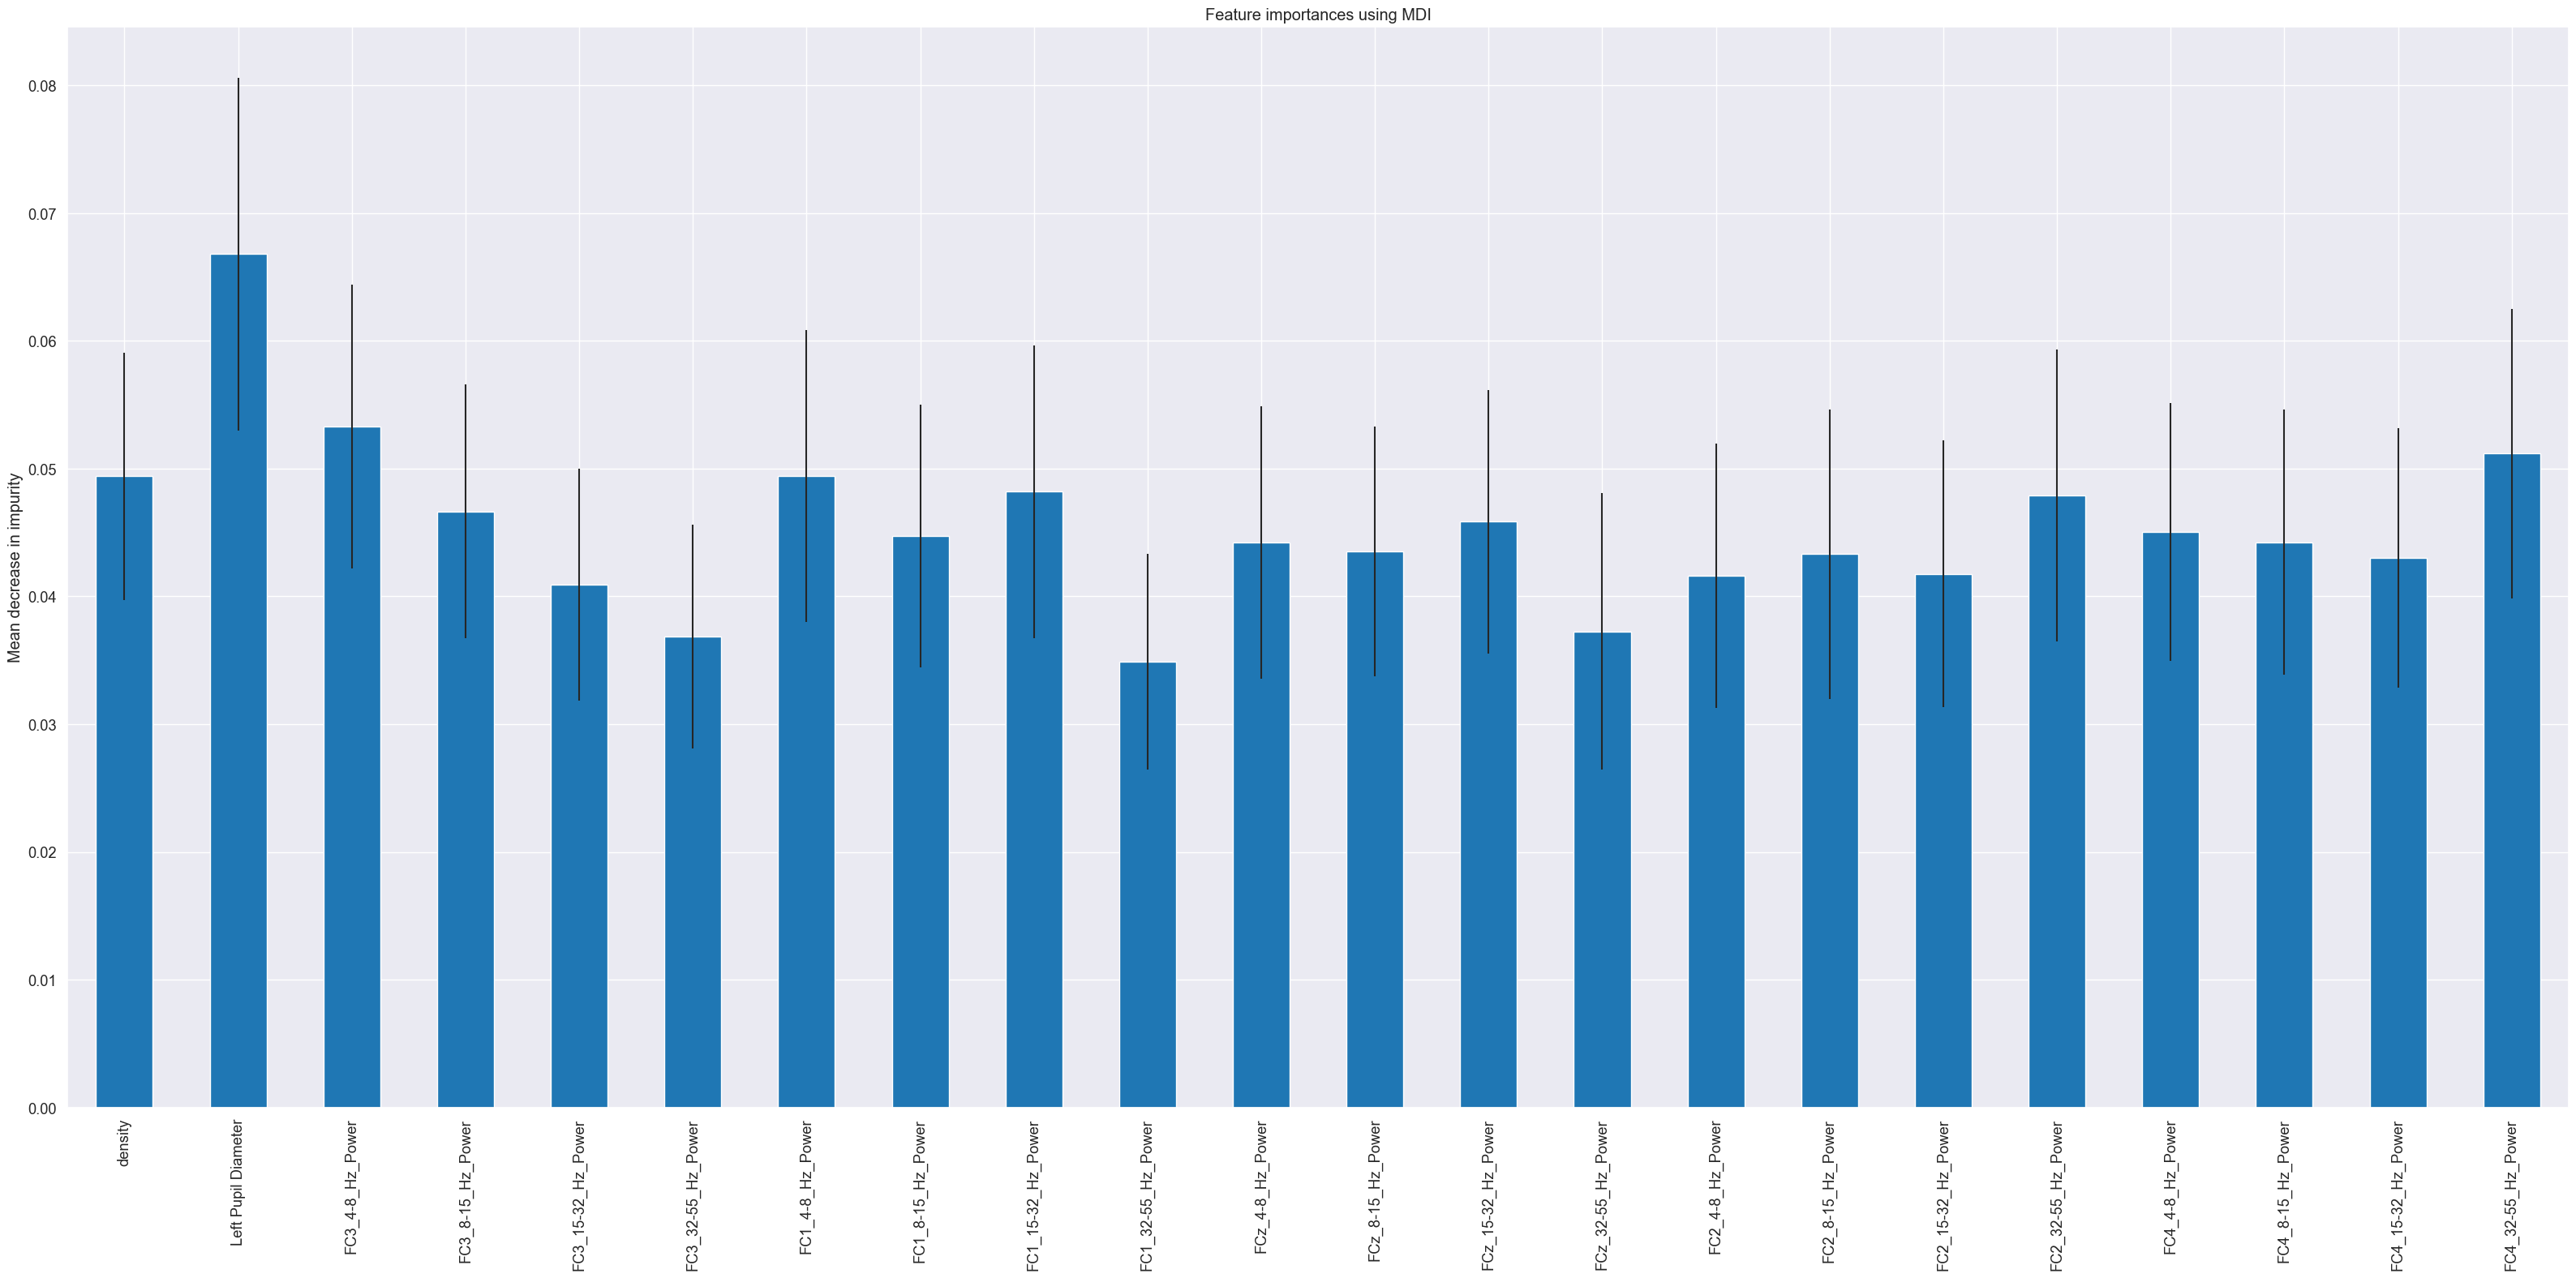

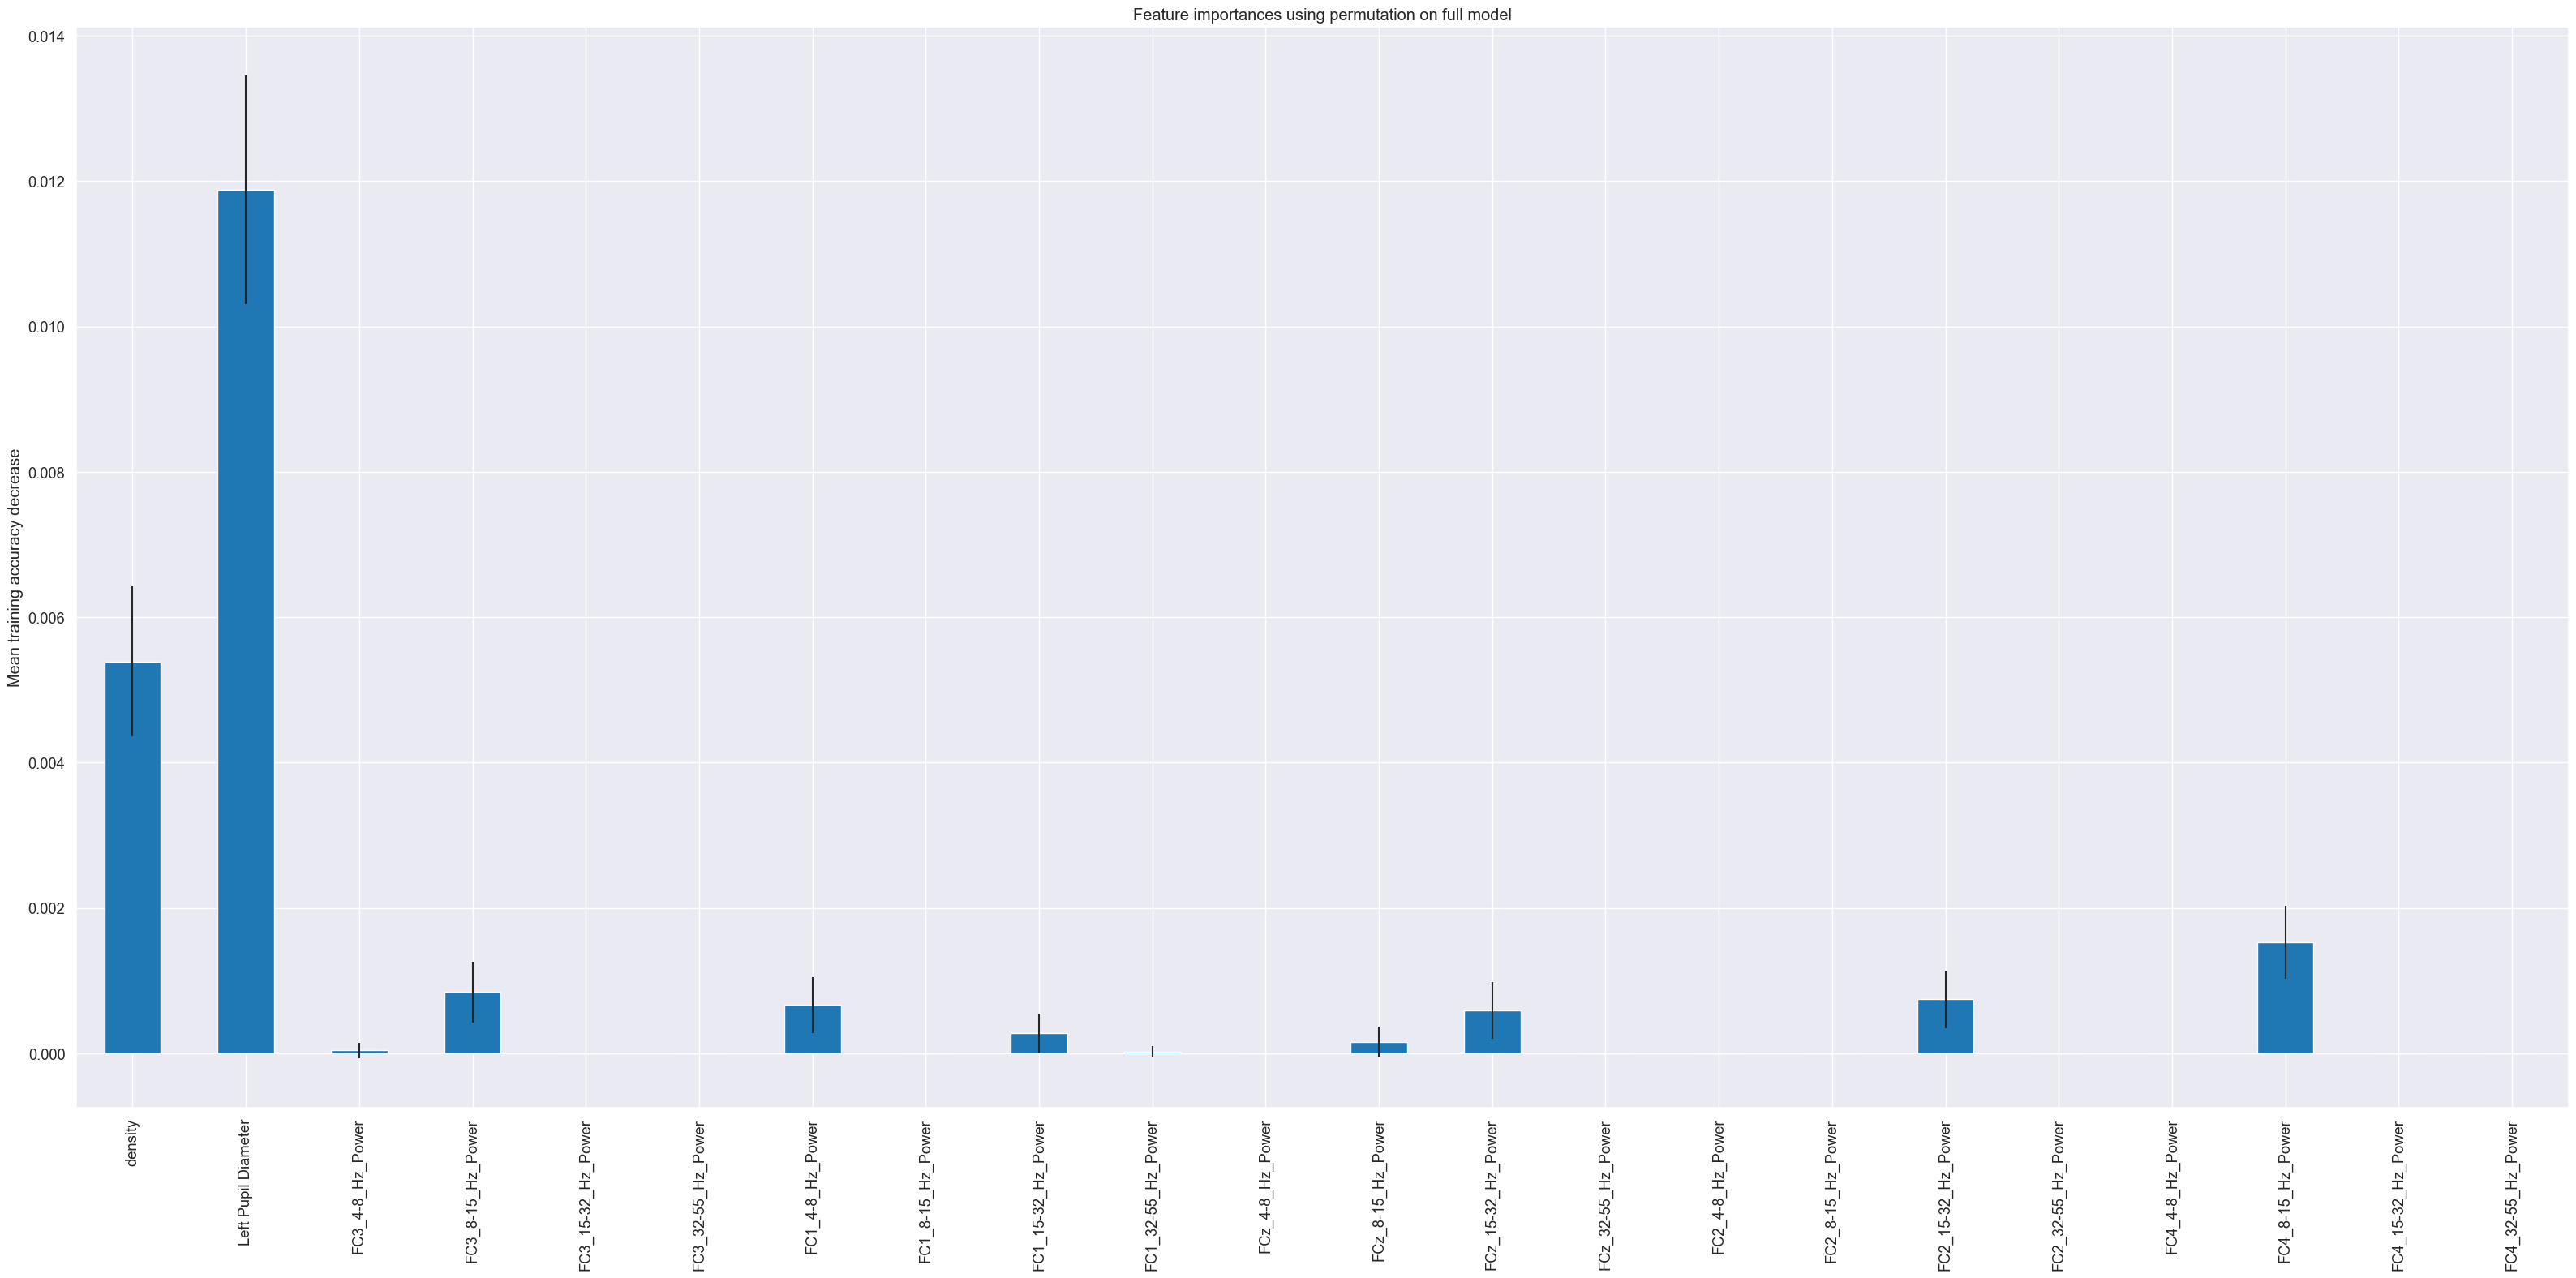

In [15]:
prediction = 'spoken_difficulty_encoded'
predictors = ['density', 'Left Pupil Diameter', 'FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power', 'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
              'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power',
              'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power']

# filter rows
trial_dfs_filtered = trial_dfs.copy()
trial_dfs_filtered = trial_dfs_filtered[trial_dfs_filtered['spoken_difficulty'] != 'unknown']

rf_prediction_importances(trial_dfs_filtered, prediction, predictors, seed=42, calc_importances=True, plot=True)

## Pupil bin prediction

### Using behavioral, eye data and autonomic meaures to predict pupil-linked arousal state

size of dataset (918, 12) lost 367 trials or 0.2856031128404669 as a result of removing nan values given the predictors
Class 1 proportion in training dataset 0.498546511627907
Test AUC: 0.6705729166666666 Accuracy: 0.6086956521739131
Elapsed time to compute the importances: 0.004 seconds
Elapsed time to compute the importances: 5.115 seconds


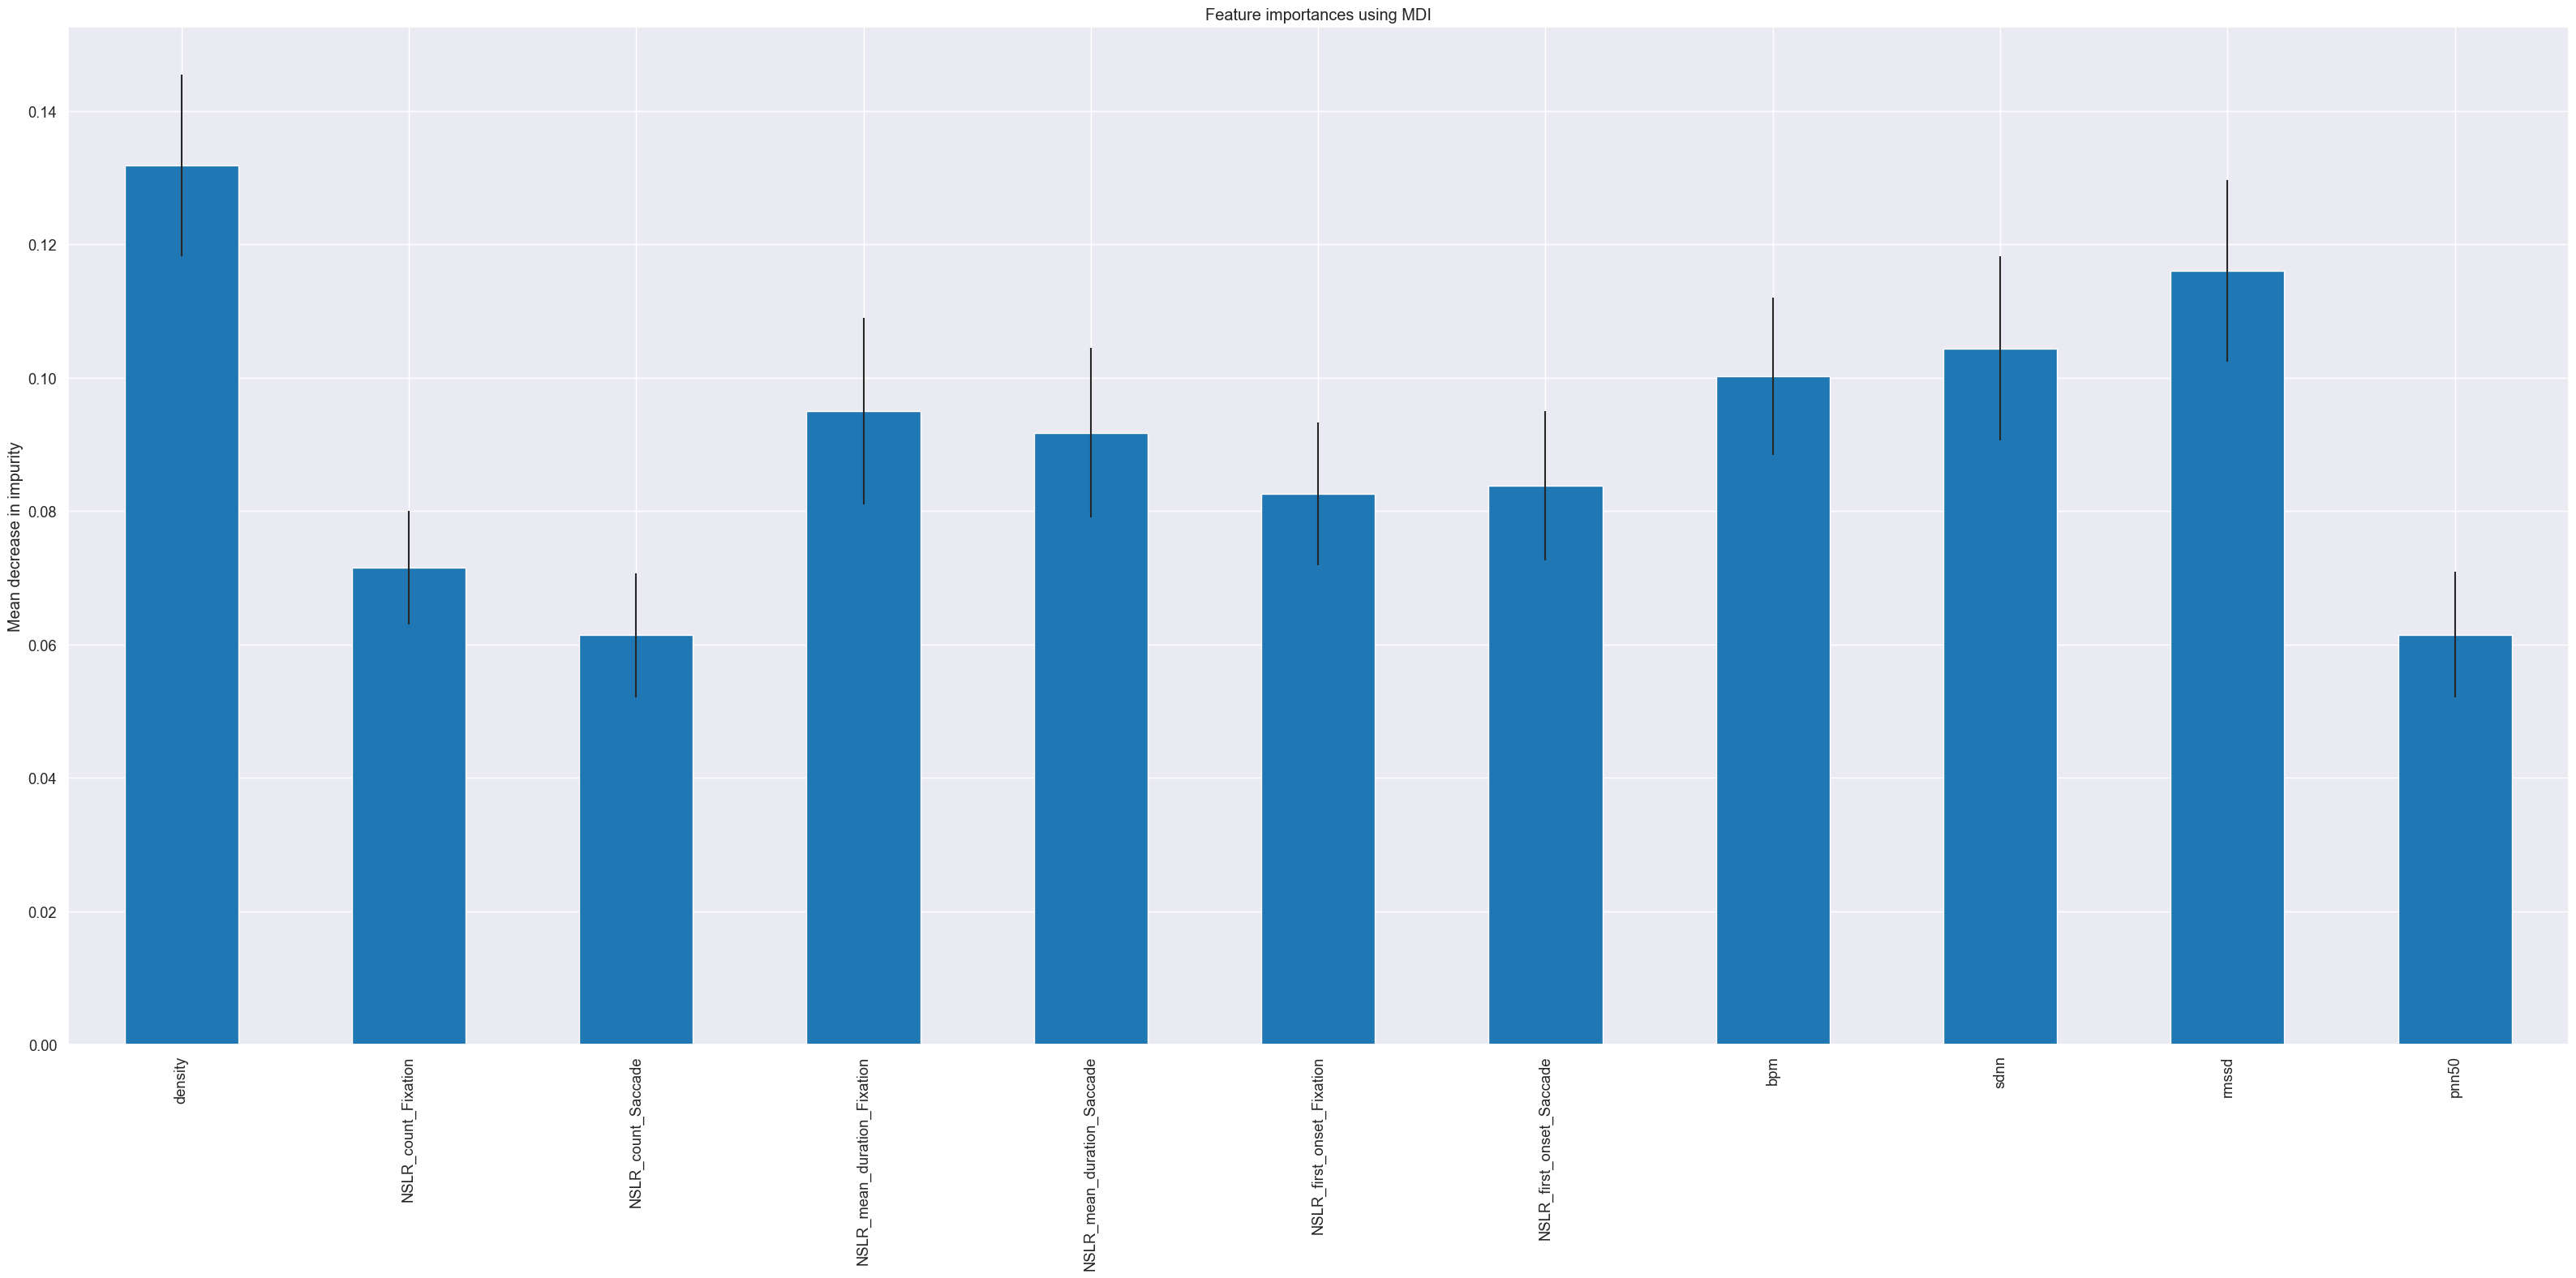

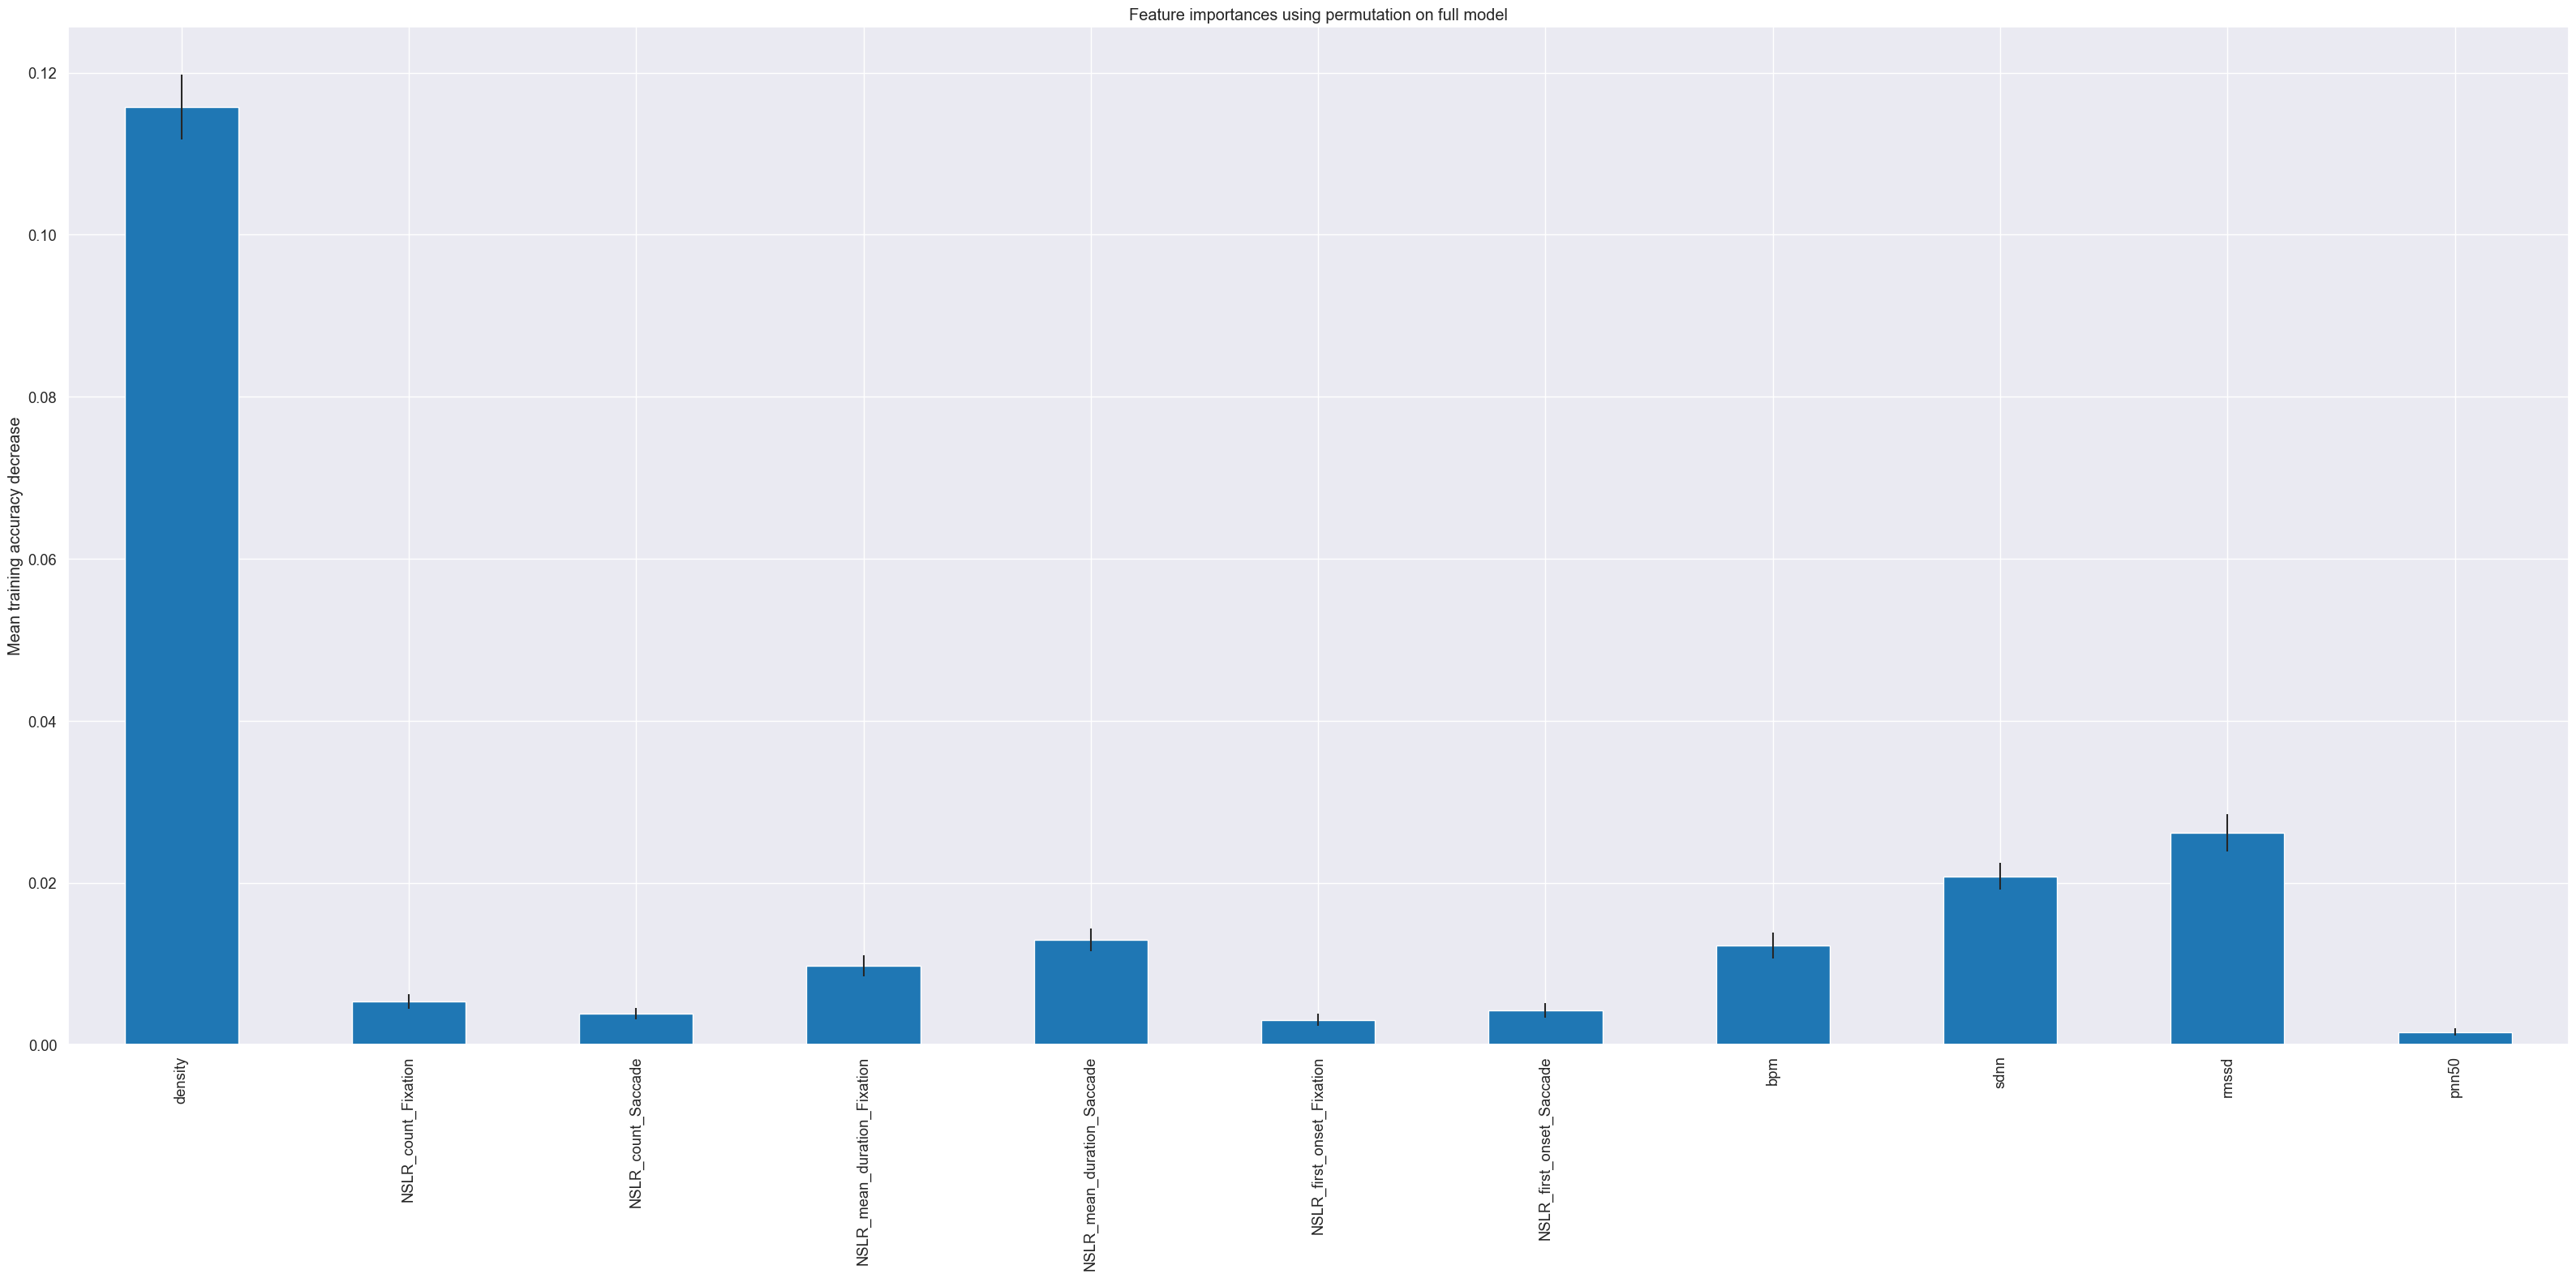

In [13]:
prediction = 'pupil_bin_encoded'  # spoken_difficulty or pupil_bin


predictors = ['density', 'NSLR_count_Fixation', 'NSLR_count_Saccade', 'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade', 'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade', 'bpm', 'sdnn', 'rmssd', 'pnn50']

# filter rows
trial_dfs_filtered = trial_dfs.copy()
trial_dfs_filtered = trial_dfs_filtered[trial_dfs_filtered['pupil_bin'].notna()]

rf_prediction_importances(trial_dfs_filtered, prediction, predictors, seed=42, calc_importances=True, plot=True)

### Using EEG to predict pupil-linked arousal

size of dataset (1285, 22) lost 0 trials or 0.0 as a result of removing nan values given the predictors
Class 1 proportion in training dataset 0.4994807892004154
Test AUC: 0.6542571660043981 Accuracy: 0.6180124223602484
Elapsed time to compute the importances: 0.004 seconds
Elapsed time to compute the importances: 12.063 seconds


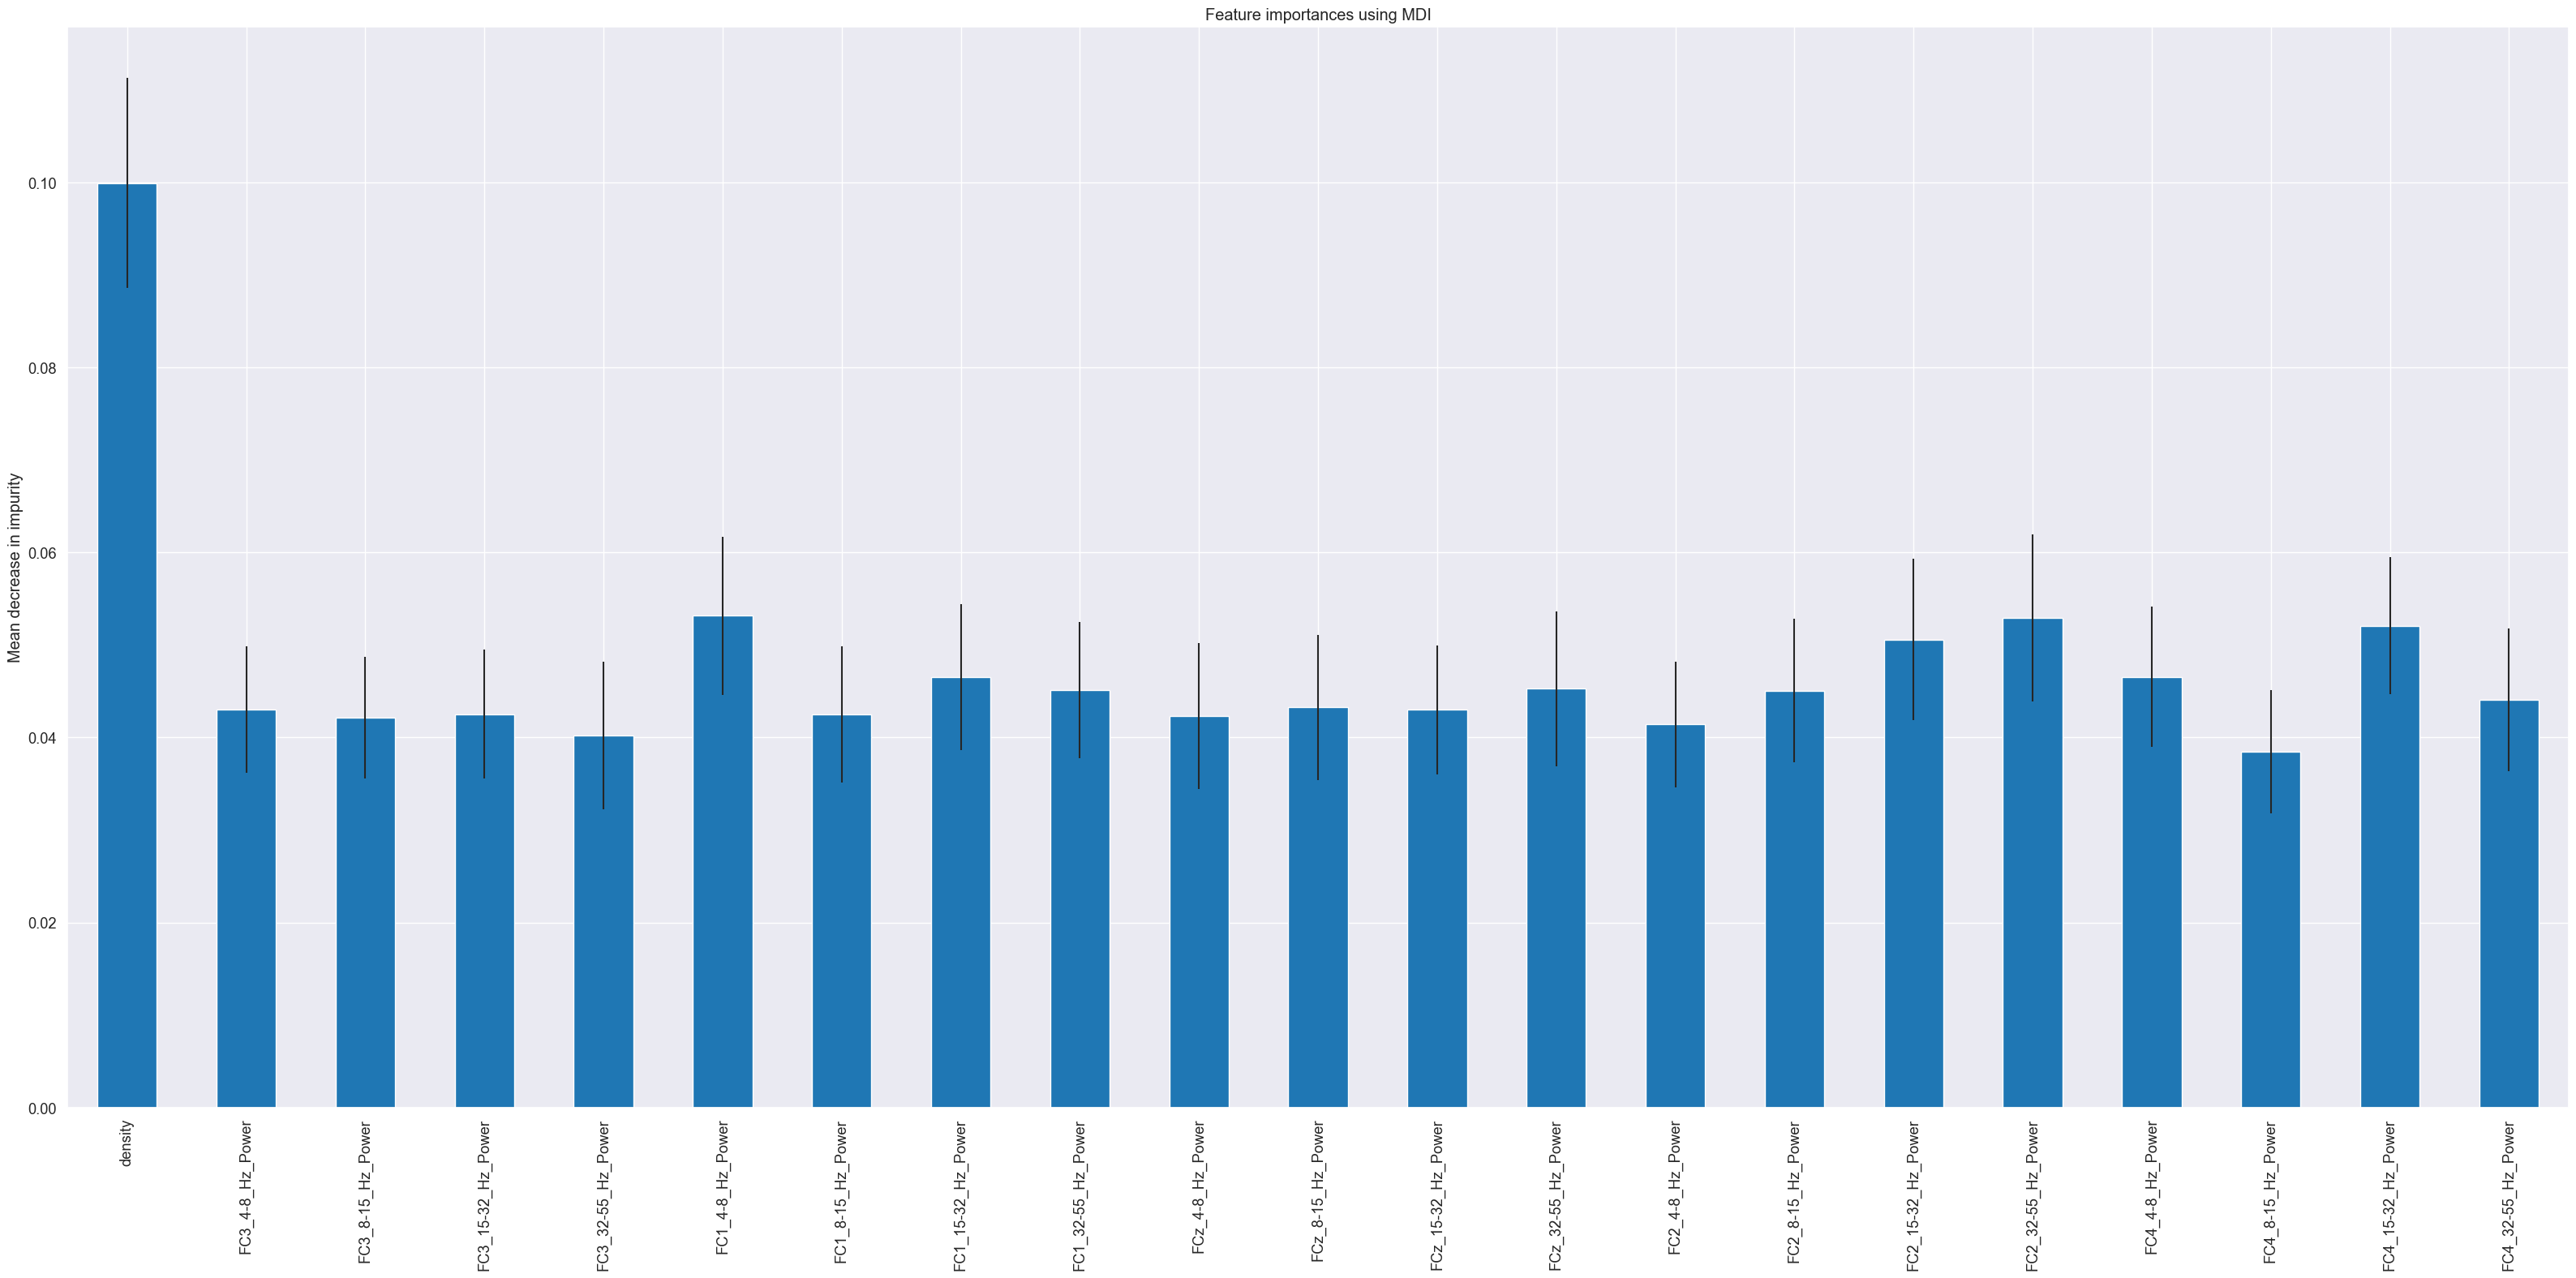

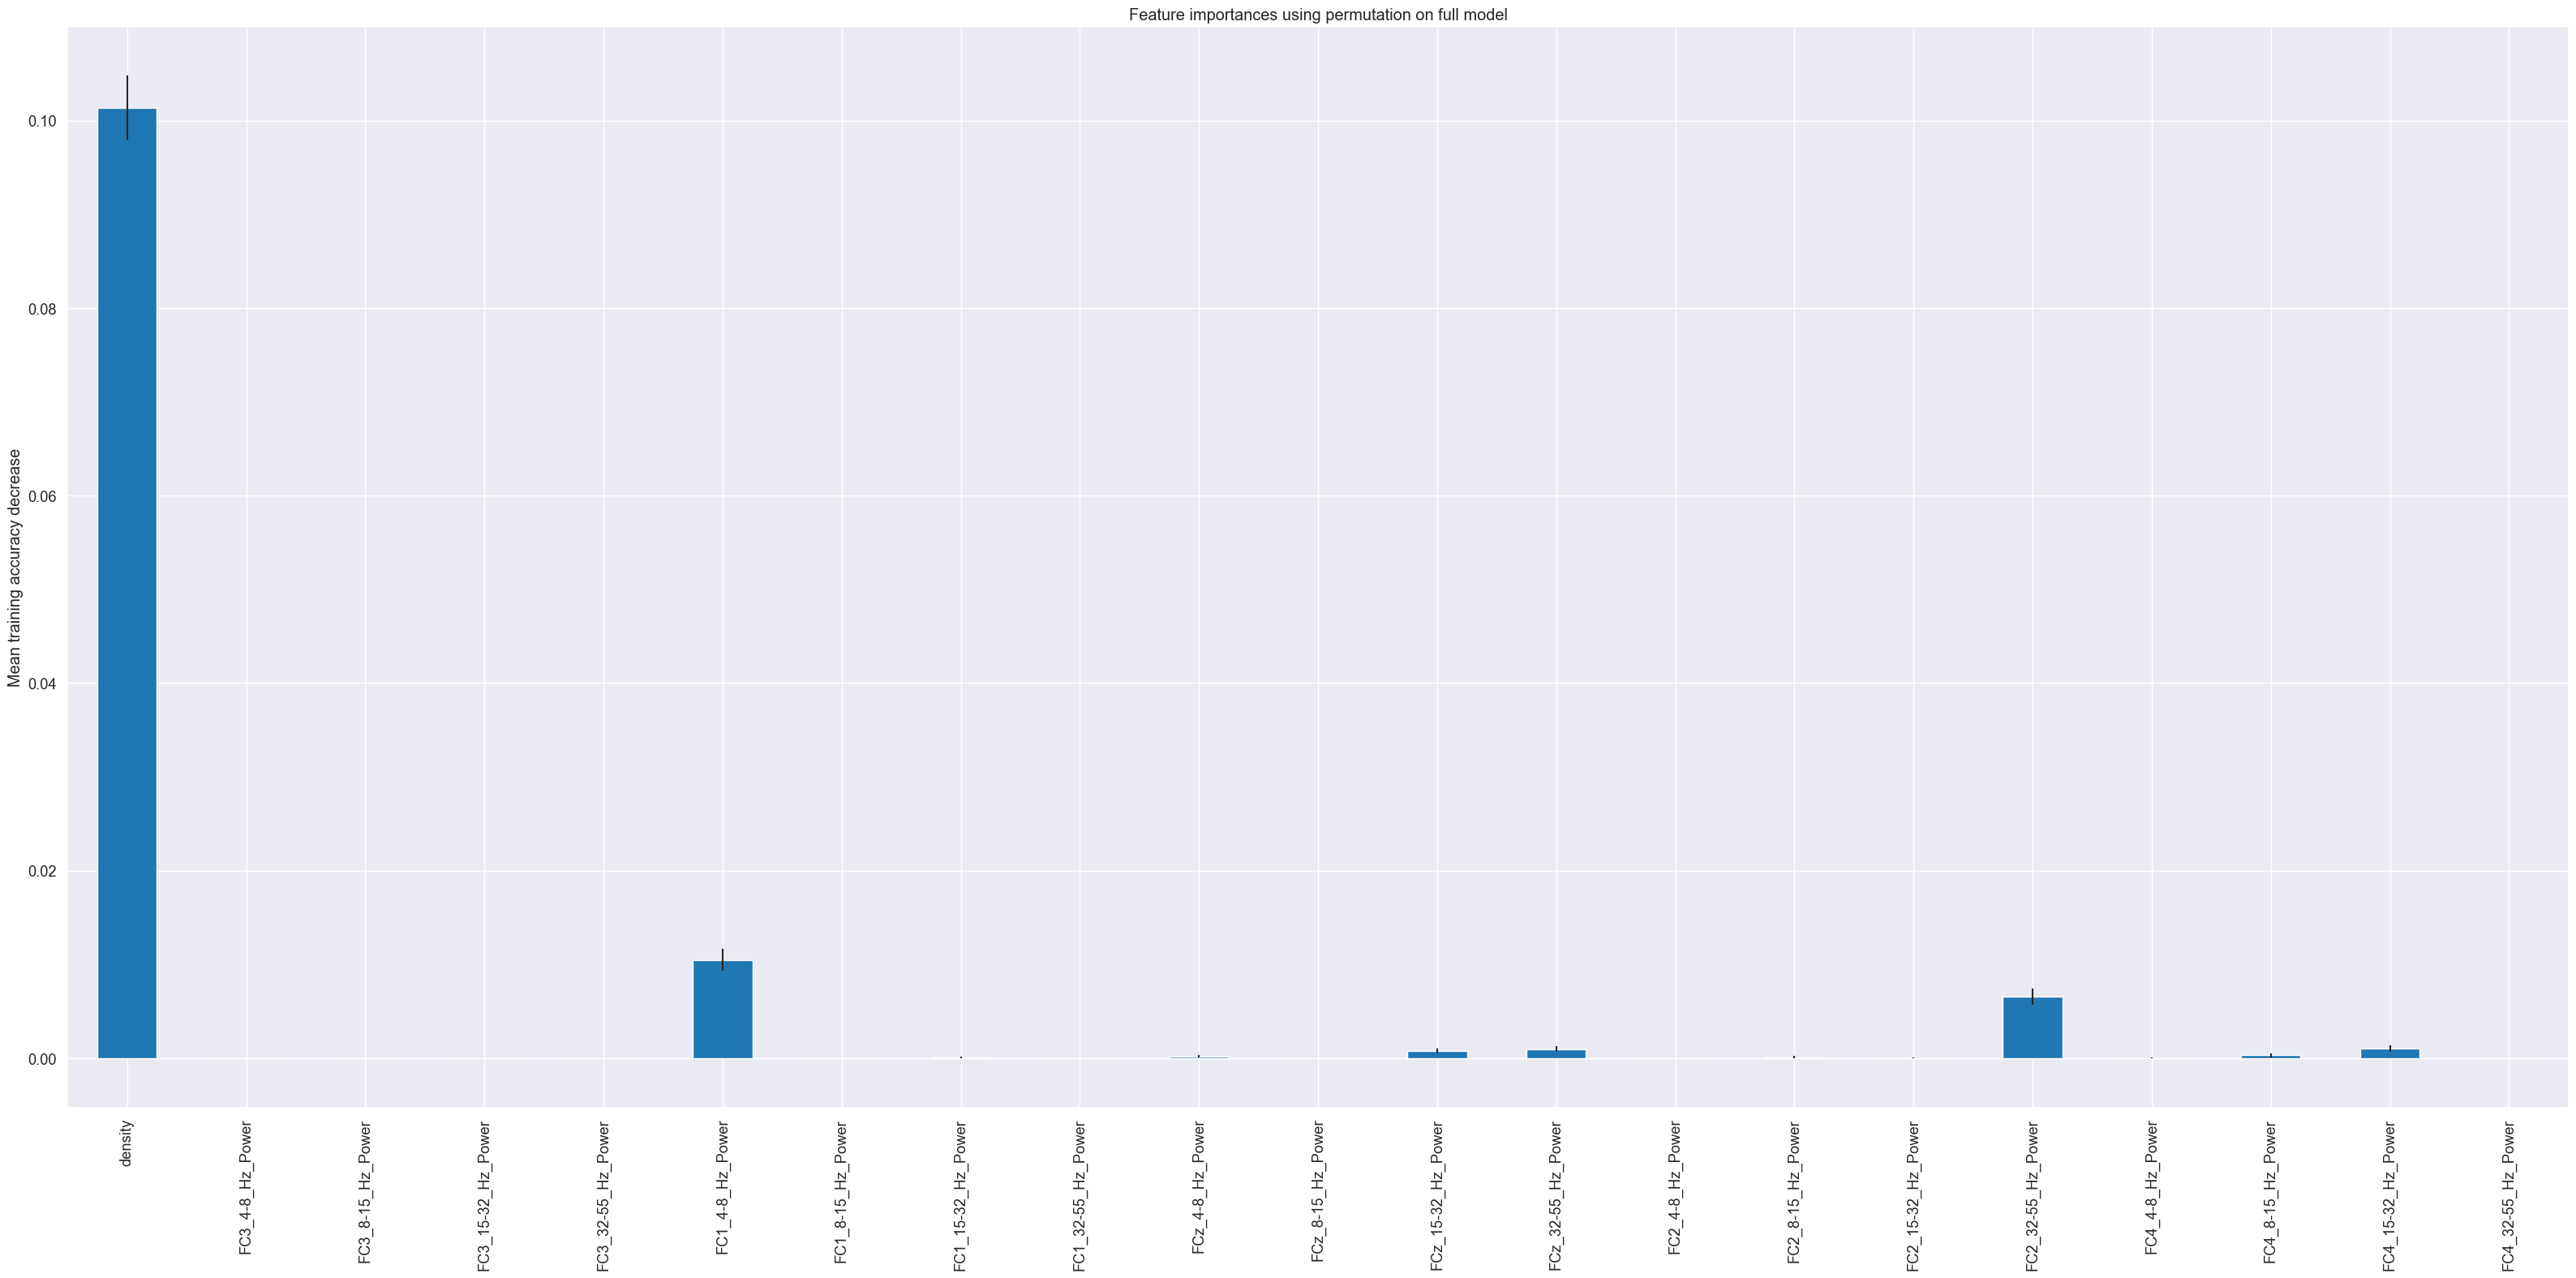

In [12]:
prediction = 'pupil_bin_encoded'  # spoken_difficulty or pupil_bin


predictors = ['density', 'FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power',
              'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
              'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power',
              'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power']

# filter rows
trial_dfs_filtered = trial_dfs.copy()
trial_dfs_filtered = trial_dfs_filtered[trial_dfs_filtered['pupil_bin'].notna()]

rf_prediction_importances(trial_dfs_filtered, prediction, predictors, seed=42, calc_importances=True, plot=True)